In [1]:
import csv
import pandas as pd
import numpy as np
import pylab as py
import datetime as dt
from datetime import date

import warnings
warnings.simplefilter('ignore')

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
from scipy import stats
from scipy.stats import kurtosis, skew
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.tsa import stattools
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
file_location = 'C:\\S&P_daily.csv'

In [5]:
f = pd.read_csv(file_location)
ori = pd.DataFrame(f)

In [6]:
ori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23239 entries, 0 to 23238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    23239 non-null  object 
 1   price   23224 non-null  float64
dtypes: float64(1), object(1)
memory usage: 363.2+ KB


In [7]:
ori['date'] = pd.to_datetime(ori.date).dt.to_period('D')

In [8]:
# Delete all data where price is NA
ori = ori[ori.price.notnull()]

# Ten worst 23-day drawdowns

In [9]:
ori.set_index('date', inplace=True)
ori.index = ori.index.to_timestamp()

In [10]:
df_23d = ori

In [11]:
df_23d['pct'] = df_23d.price.pct_change(23) 

In [12]:
crash10 = df_23d.nsmallest(10, ['pct'])

In [13]:
# Top 10 stock market drawdowns over a 23-day period, 1928-2020
crash10

,price,pct
date,,
1929-11-13,17.66,-0.416584
1929-11-12,18.73,-0.382663
1929-11-14,19.24,-0.375527
1931-10-05,8.82,-0.366379
1929-11-11,19.86,-0.347569
1929-10-29,20.43,-0.343720
1929-11-18,20.09,-0.342390
1929-11-15,20.30,-0.340052
2020-03-23,2237.40,-0.339250


**Twenty-three trading days** separated the historic high on the S&P500 on 19 February 2020 and the nadir on 23 March 2020, based on closing prices. The S&P500 fell **33.92% in those 23 days**. The drawdown over those 23 days was among the **largest ever experienced** in the history of the index, surpassed only by the crashes in **1929 and 1931** that preceded the Great Depression. The 2020 drawdown was certainly the largest of its kind in the post-WWII stock market experience, though the -29.12% fall in **October 1987** (in a similar 23-day period) was not far behind in magnitude.

# Create daily, monthly & quarterly returns time series

In [14]:
# Restricting the data sample through new year's eve 2020
df = ori.loc[(ori.index <= '2019-12-31')]

In [15]:
# To downsample the data to monthly frequency, 
# while keeping the last price value of the month (the date defaults to month-end)
dfm = df.sort_index().resample("M").apply(lambda ser: ser.iloc[-1,])

In [16]:
# To downsample the data to quarterly frequency, 
dfq = df.sort_index().resample("Q").apply(lambda ser: ser.iloc[-1,])

In [17]:
# Creating daily percentage change in the daily series
df['dy_pct'] = df.price.pct_change() 

In [18]:
df.head(10)

,price,pct,dy_pct
date,,,
1927-12-30,17.66,NaN,NaN
1928-01-03,17.76,NaN,0.005663
1928-01-04,17.72,NaN,-0.002252
1928-01-05,17.55,NaN,-0.009594
1928-01-06,17.66,NaN,0.006268
1928-01-09,17.50,NaN,-0.009060
1928-01-10,17.37,NaN,-0.007429
1928-01-11,17.35,NaN,-0.001151
1928-01-12,17.47,NaN,0.006916


In [19]:
# Creating monthly percentage change in the monthly series
dfm['mt_pct'] = dfm.price.pct_change() 

In [20]:
dfm.head(10)

,price,pct,mt_pct
date,,,
1927-12-31,17.66,NaN,NaN
1928-01-31,17.57,NaN,-0.005096
1928-02-29,17.26,-0.014840,-0.017644
1928-03-31,19.28,0.123543,0.117034
1928-04-30,19.75,0.042767,0.024378
1928-05-31,20.00,0.016260,0.012658
1928-06-30,19.14,-0.021972,-0.043000
1928-07-31,19.43,0.030223,0.015152
1928-08-31,20.87,0.074112,0.074112


In [21]:
# Creating quarterly percentage change in the quarterly series
dfq['qt_pct'] = dfq.price.pct_change() 

In [22]:
# Delete all data where price is NA, which will result in a sample period of start-1928 through end-2019
df = df[df.dy_pct.notnull()]

In [23]:
# Same for the monthly series
dfm = dfm[dfm.mt_pct.notnull()]

In [24]:
# and quarterly series
dfq = dfq[dfq.qt_pct.notnull()]

**Volatility clustering** is easily observable in the **daily returns series**, with concentrated periods of large absolute returns juxtaposed against more placid periods of persistent smaller absolute returns. The volatility clustering becomes less obvious in the **monthly series**.

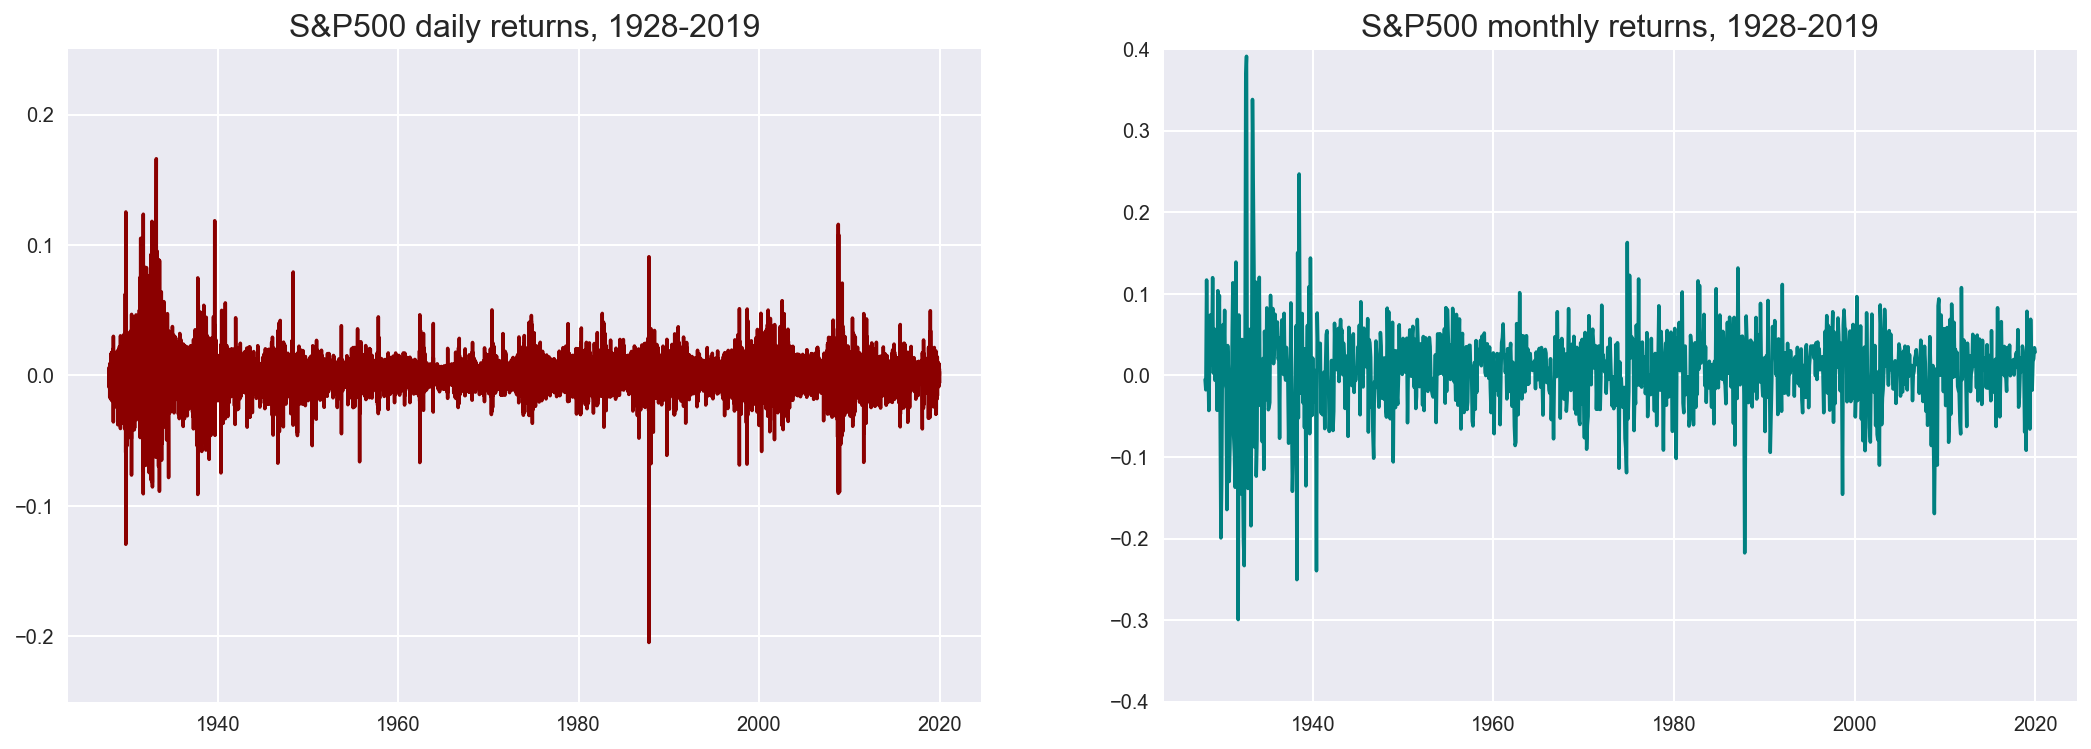

In [25]:
fig, ax = plt.subplots(ncols=2, figsize=(18, 6))


ax[0].plot(df.dy_pct, color='darkred')
ax[0].set_title('S&P500 daily returns, 1928-2019', fontsize=16)
ax[0].set_ylim([-0.25, 0.25])

ax[1].plot(dfm.mt_pct, color='teal')
ax[1].set_title('S&P500 monthly returns, 1928-2019', fontsize=16)
ax[1].set_ylim([-0.40, 0.40])
plt.show()

# Are stock market returns normally distributed?

The daily returns histogram has a much **longer left-tail** compared to the right-tail, which is less obvious in the monthly returns histogram. This is the _**aggregational normality**_ phenomenon where longer horizon returns are closer to a normal distribution

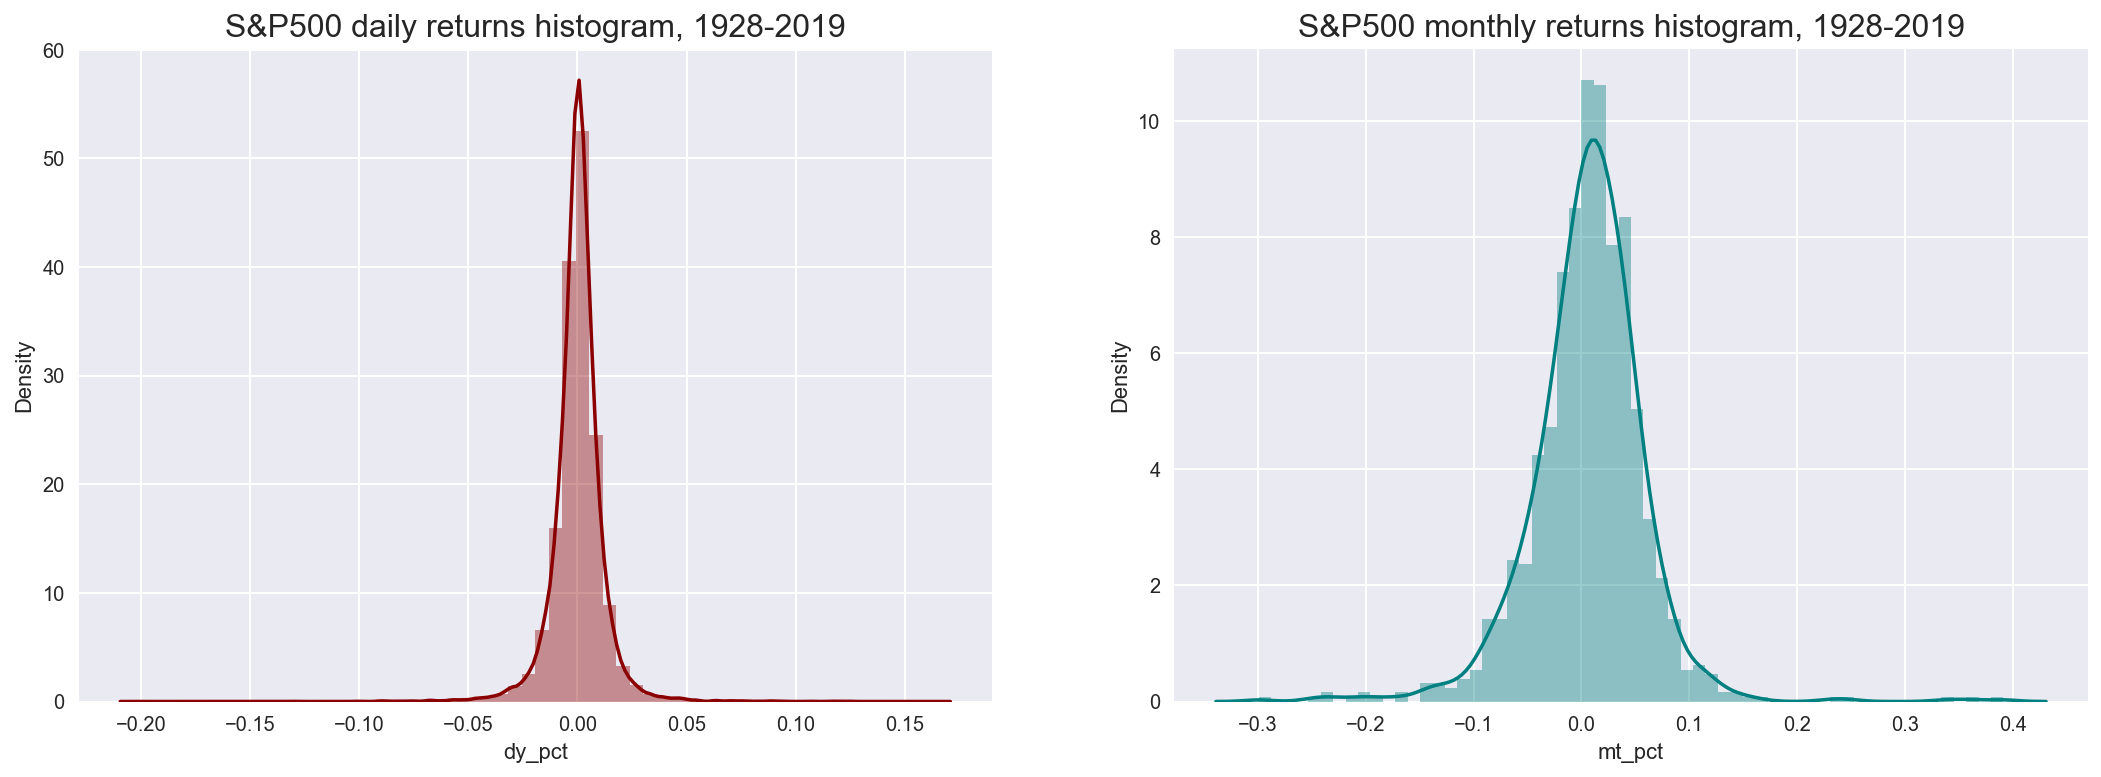

In [26]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(18, 6))

sns.distplot(df.dy_pct, bins=60, kde=True, ax=ax1, color='darkred')
ax1.set_title('S&P500 daily returns histogram, 1928-2019', fontsize=16)

sns.distplot(dfm.mt_pct, bins=60, kde=True, color='teal', ax=ax2)
ax2.set_title('S&P500 monthly returns histogram, 1928-2019', fontsize=16)
plt.show()

In [27]:
# 1.00029 to the power of 21 (average trading days in a month) is 1.0061. So the link between the two means looks correct.
print(np.mean(df.dy_pct), np.mean(dfm.mt_pct))

0.0002937260720283883 0.006171737210913708


Below are some formal measures of **excess kurtosis and skewness** for both daily and monthly returns series. _**Kurtosis**_ is a measure of the size of the tails relative to the rest of the distribution. In this case, we see that both distributions exhibit "fat tails" relative to the normal distribution. The **daily returns show much fatter tails than the monthly series** (i.e. excess kurtosis of 17.40 vs 8.16). 

A **skewness measure between +0.5 and -0.5** may be considered to indicate a fairly symmetrical distribution, as is the case here for both distributions. 

In [28]:
# Kurtosis and skewness for the daily return series
print(f'Excess kurtosis of daily returns distribution (normal=0): {kurtosis(df.dy_pct):0.4f}')
print(f'Skewness of daily returns distribution (normal = 0): {skew(df.dy_pct):0.4f}')

Excess kurtosis of daily returns distribution (normal=0): 17.4038
Skewness of daily returns distribution (normal = 0): -0.0874


In [29]:
# Kurtosis and skewness for the monthly return series
print(f'Excess kurtosis of monthly returns distribution (normal=0): {kurtosis(dfm.mt_pct):0.4f}')
print(f'Skewness of monthly returns distribution (normal=0): {skew(dfm.mt_pct):0.4f}')

Excess kurtosis of monthly returns distribution (normal=0): 8.1592
Skewness of monthly returns distribution (normal=0): 0.1358


### Comparative q-q plots & box-plots

Need to **standardise the respective returns series** before comparing their respective **q-q plots and boxplots**. Standardization results in each series having a **mean=0 and standard deviation=1**, which allows for a more appropriate comparison of their respective distributions.

In [30]:
dy = df.dy_pct
mt = dfm.mt_pct

In [31]:
scaler = StandardScaler()

In [32]:
# Standardise the daily and monthly data, and the output are two Numpy arrays
dy_scaled = scaler.fit_transform(df[['dy_pct']]) 
mt_scaled = scaler.fit_transform(dfm[['mt_pct']])

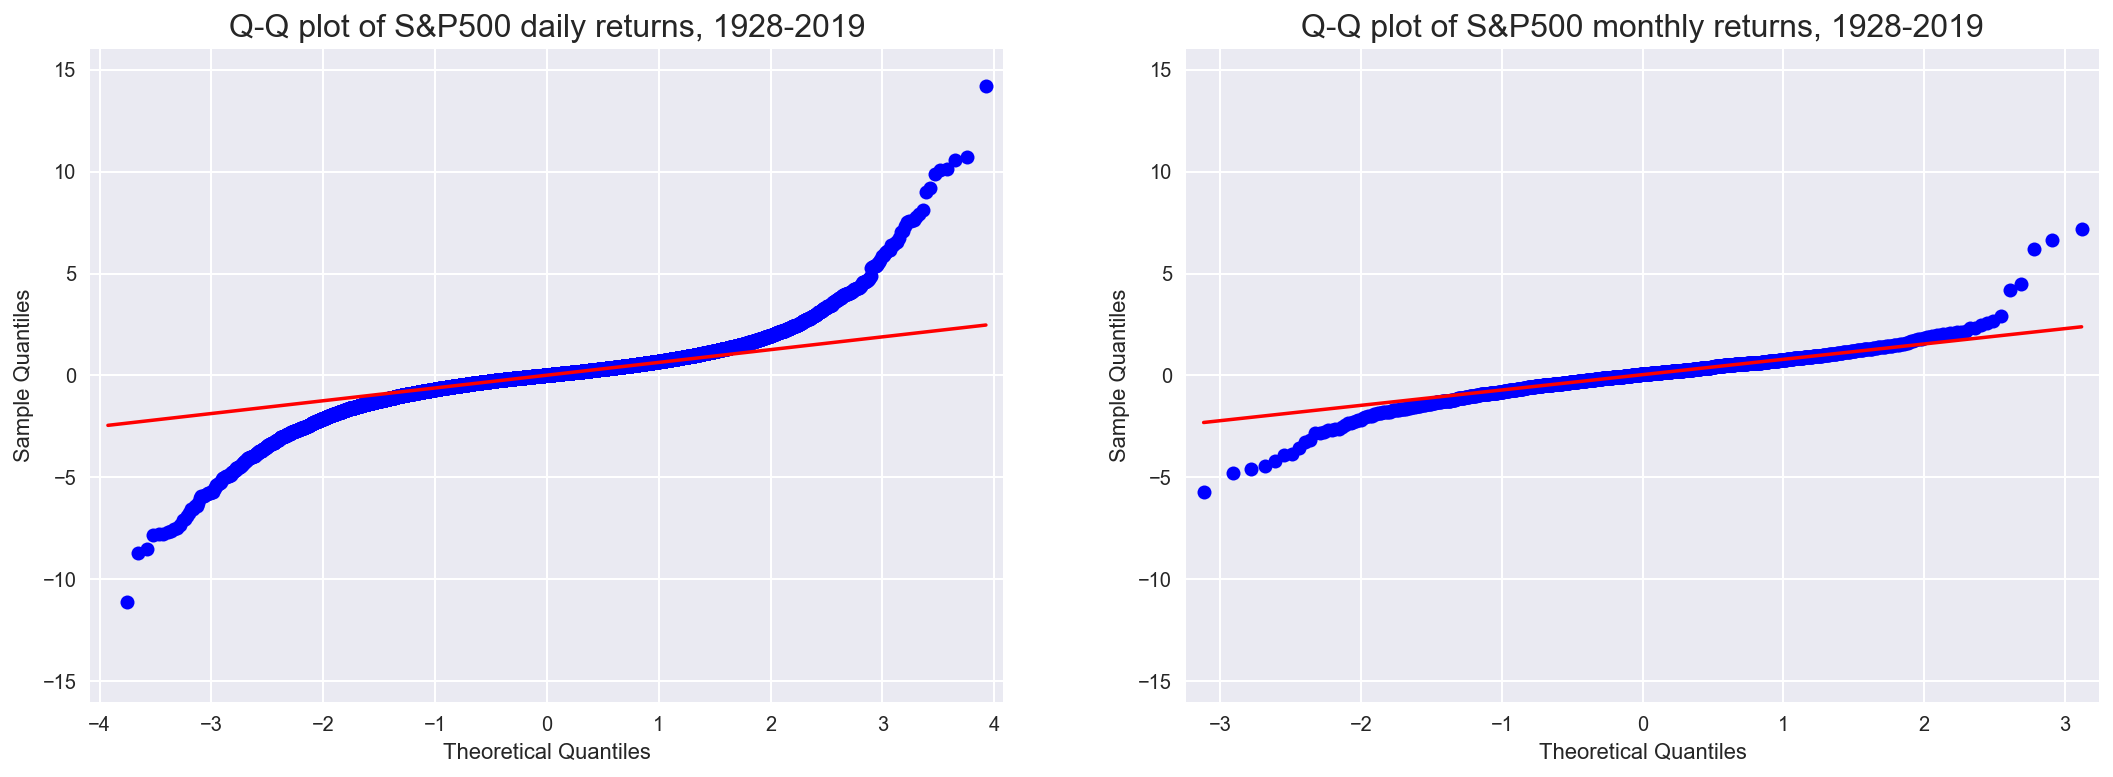

In [33]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(18, 6))

sm.qqplot(dy_scaled.ravel(), line='q', ax=ax1)
ax1.set_title('Q-Q plot of S&P500 daily returns, 1928-2019', fontsize=16)
ax1.set_ylim([-16, 16])

sm.qqplot(mt_scaled.ravel(), line ='q', ax=ax2)
ax2.set_title('Q-Q plot of S&P500 monthly returns, 1928-2019', fontsize=16)
ax2.set_ylim([-16, 16])
plt.show()

The **quantile-quantile (qq) plots** above highlight the infamous **"fat tails" in stock market returns**. The distribution of historical returns are plotted against a theoretical normal distribution. If the sets of historical returns lie entirely along the red line, then the returns are normally distributed. It is obvious from the plots that this is not the case, for both the daily and monthly returns. **The deviations from the red line denote how much the sample distribution deviates from the normal distribution**.

**Positive values** in the historical returns are larger than expected in a normal distribution, while **negative values** are more deeply negative than expected. So the returns' distribution have **fatter tails**. But the deviation from normality is **smaller in the monthly returns** data compared to the daily data.

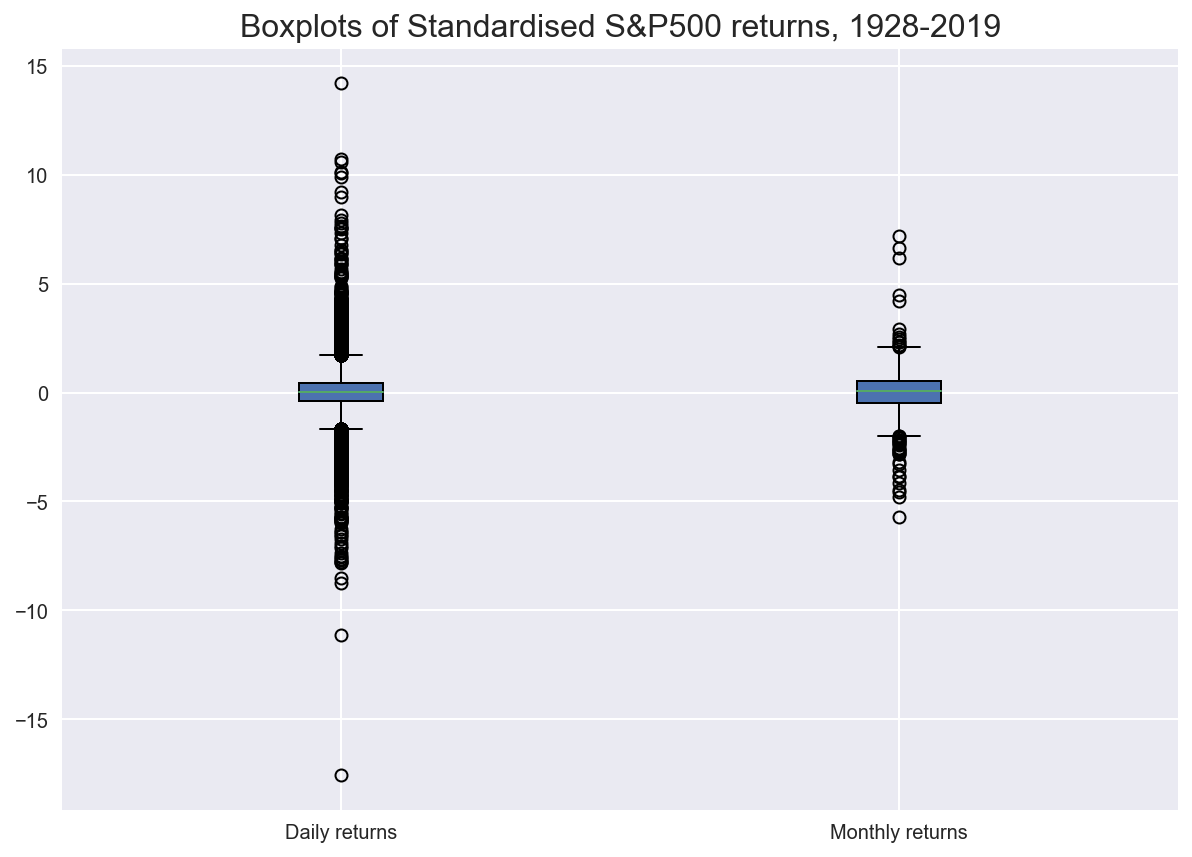

In [34]:
fig, ax = plt.subplots(figsize=(10, 7))

box_data=[dy_scaled.ravel(), mt_scaled.ravel()] # Need to flatten the Numpy arrays
ax.boxplot(box_data, patch_artist=True, labels=['Daily returns','Monthly returns'])
ax.set_title('Boxplots of Standardised S&P500 returns, 1928-2019', fontsize=16)
plt.show()

As is again evident, we find that the box-plot of the daily returns series has **further outliers** than the monthly series. The daily series also has more extreme outliers on the negative side, compared to the monthly data. This showcases the _**aggregational normality**_ phenomenon.

We may conclude that stock market returns for both daily and monthly series **do not follow a normal distribution**. In particular, the distributions of historical returns have **fatter tails** than normal distributions. There is also a tendency for more of a left-skew indicating more negative outliers in both series. The **monthly series however appears closer to the normal distribution ideal compared to the daily series**.

# Non-linear autocorrelation in returns

In [35]:
def autocorr_plots(y, lags=20, alpha=0.05):
    """
    Plot autocorrelations and partial autocorrelations
    Arguments:
    y: Time series data
    lags: Number of lags to plot
    alpha: Confidence level for random noise
    """
    se = stats.norm().ppf(1-alpha/2)/np.sqrt(len(y))
    
    fig, ax = plt.subplots(ncols=2, figsize=(18, 6), sharey=True)
    
    plot_acf(y, lags=lags, alpha=alpha, ax=ax[0], color='darkmagenta')
    ax[0].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)
    ax[0].set_title('Autocorrelation', fontsize=16)
    
    plot_pacf(y, lags=lags, alpha=alpha, ax=ax[1], method='ywmle', color='darkmagenta')
    ax[1].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)
    ax[1].set_title('Partial Autocorrelation', fontsize=16)
    
    return fig, ax

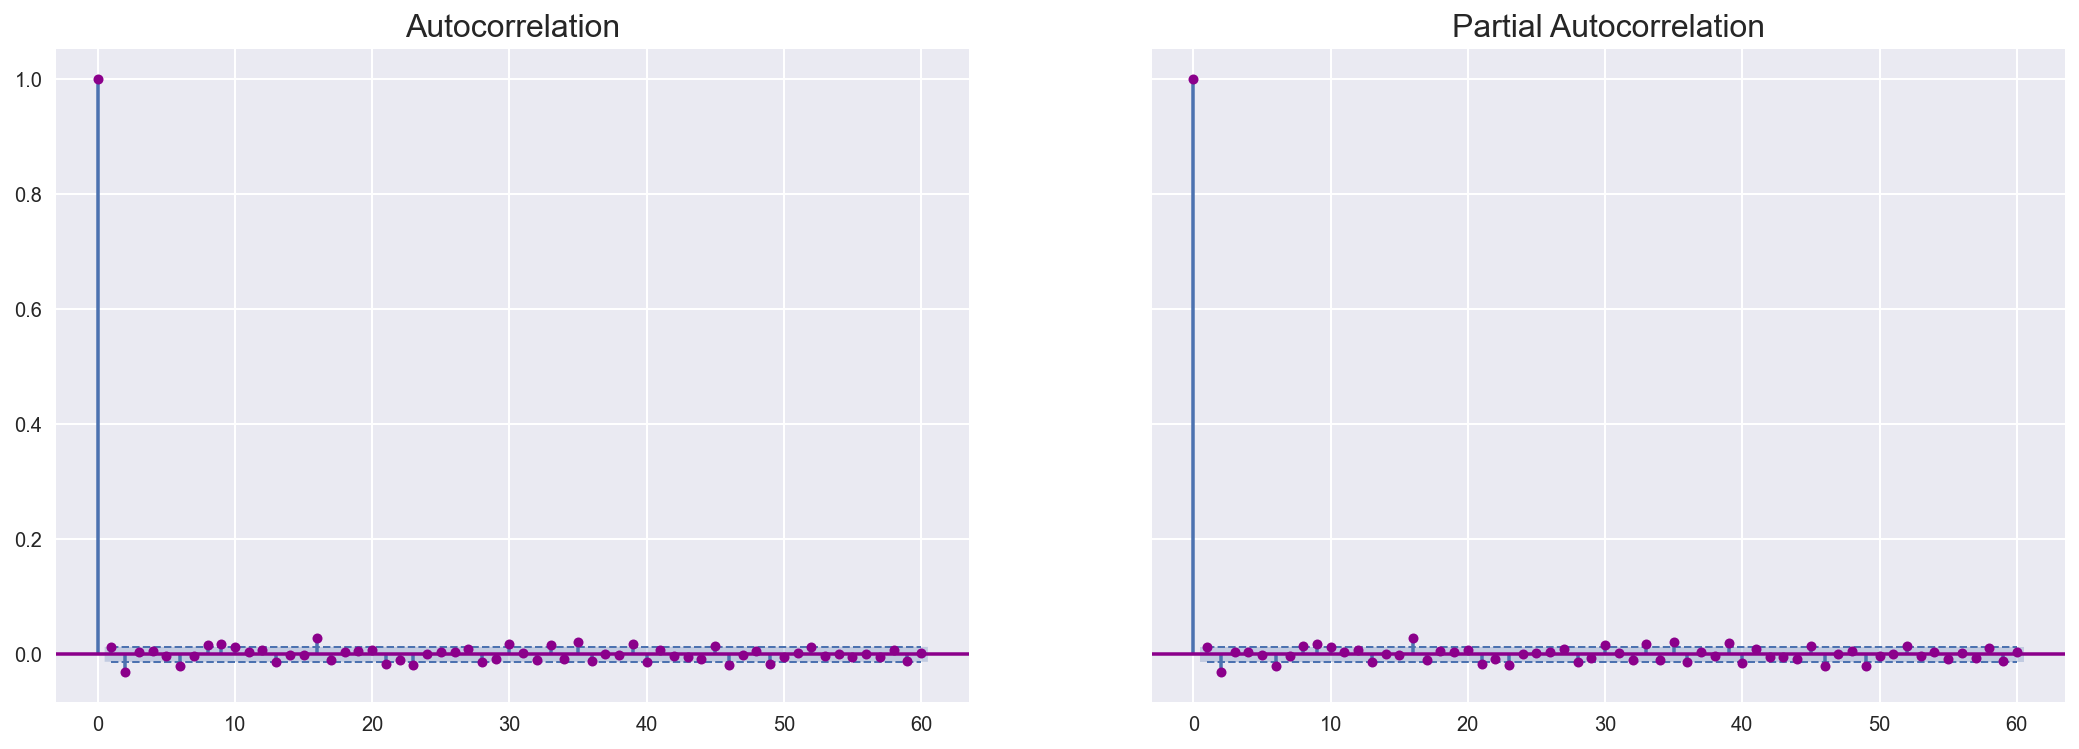

In [36]:
# Daily percent returns appear have no obvious serial correlation
fig, ax = autocorr_plots(df.dy_pct, lags=60)

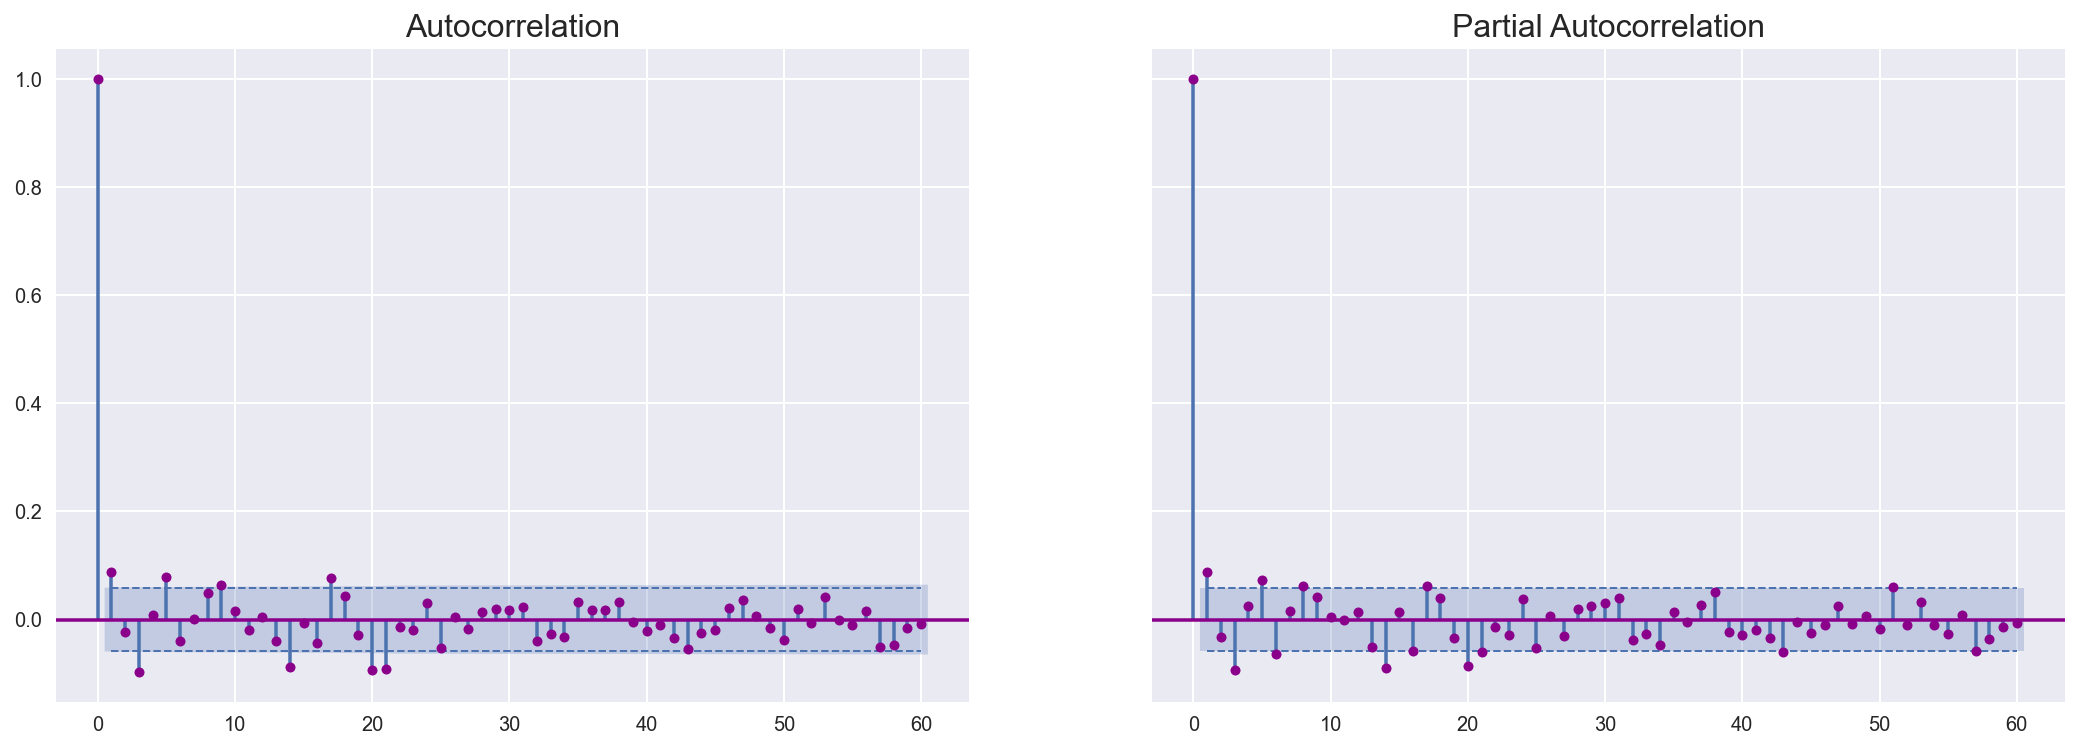

In [37]:
# Monthly percent returns also appear have no obvious problem with serial correlation
fig, ax = autocorr_plots(dfm.mt_pct, lags=60)

Both daily and monthly returns appear to **lack linear autocorrelation**, which is good news. But we haven't ruled out **non-linear autocorrelation**.

To examine non-linear autocorrelation we need to take either the **absolute values of the returns**, or their squared values. Then we plot the respective autocorrelation plots again.

In [38]:
# Creating a series of squared returns (basically an absolute return measure)
df['dy_pct_sq'] = df.dy_pct**2

In [39]:
dfm['mt_pct_sq'] = dfm.mt_pct**2

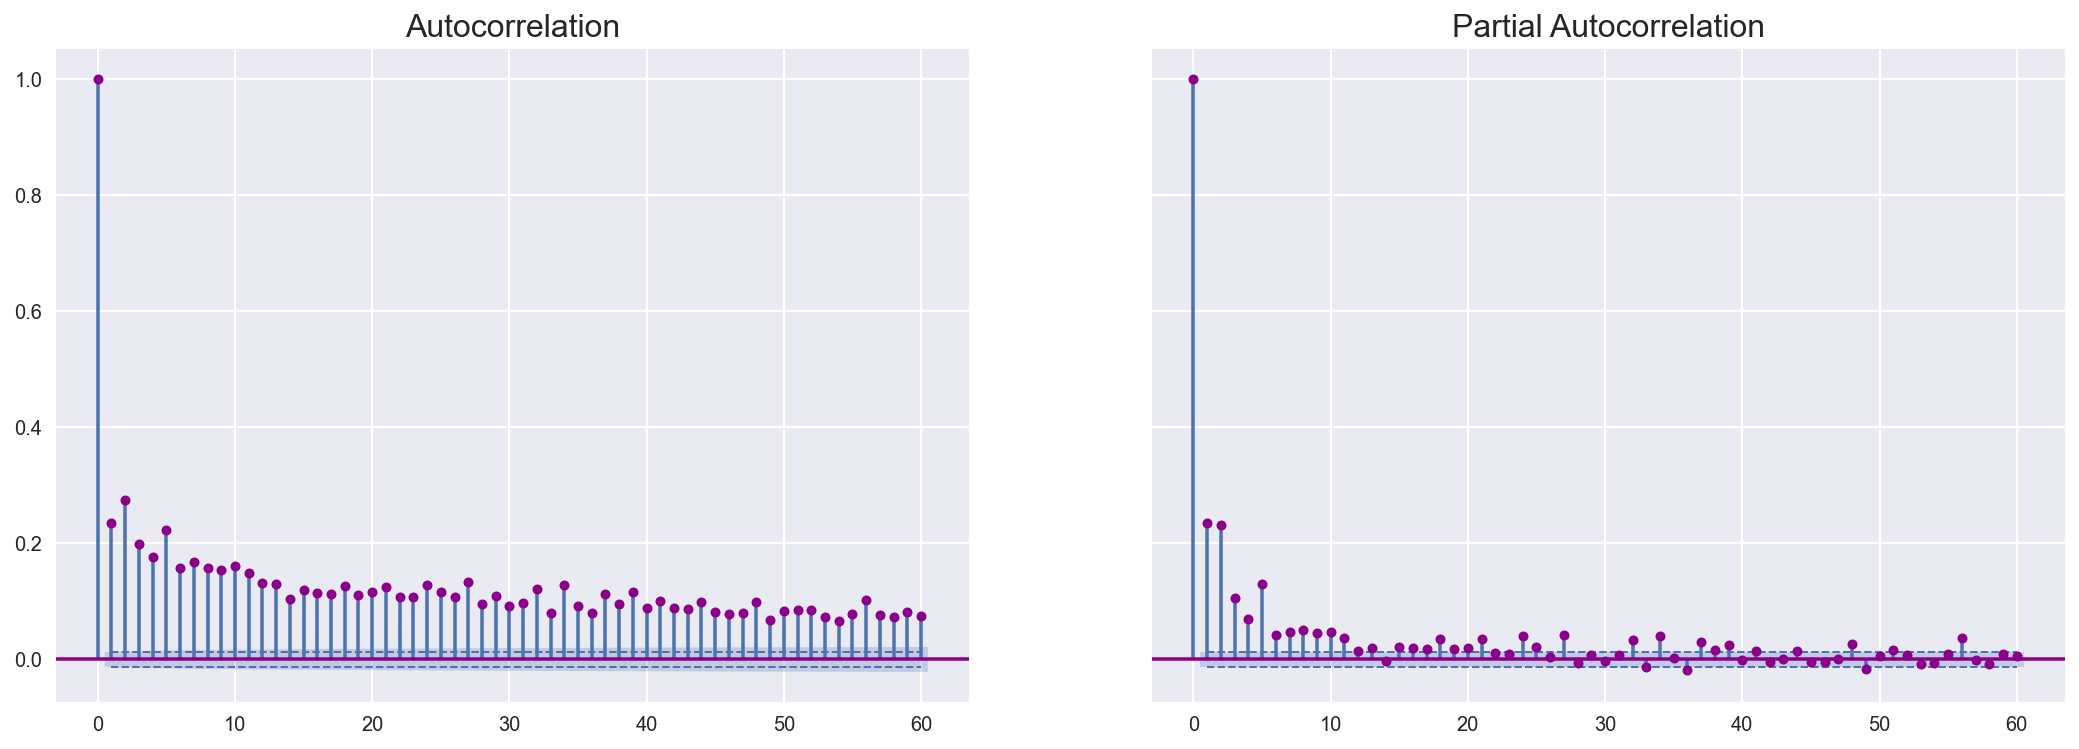

In [40]:
# Daily squared returns exhibit clear serial correlation
fig, ax = autocorr_plots(df.dy_pct_sq, lags=60)

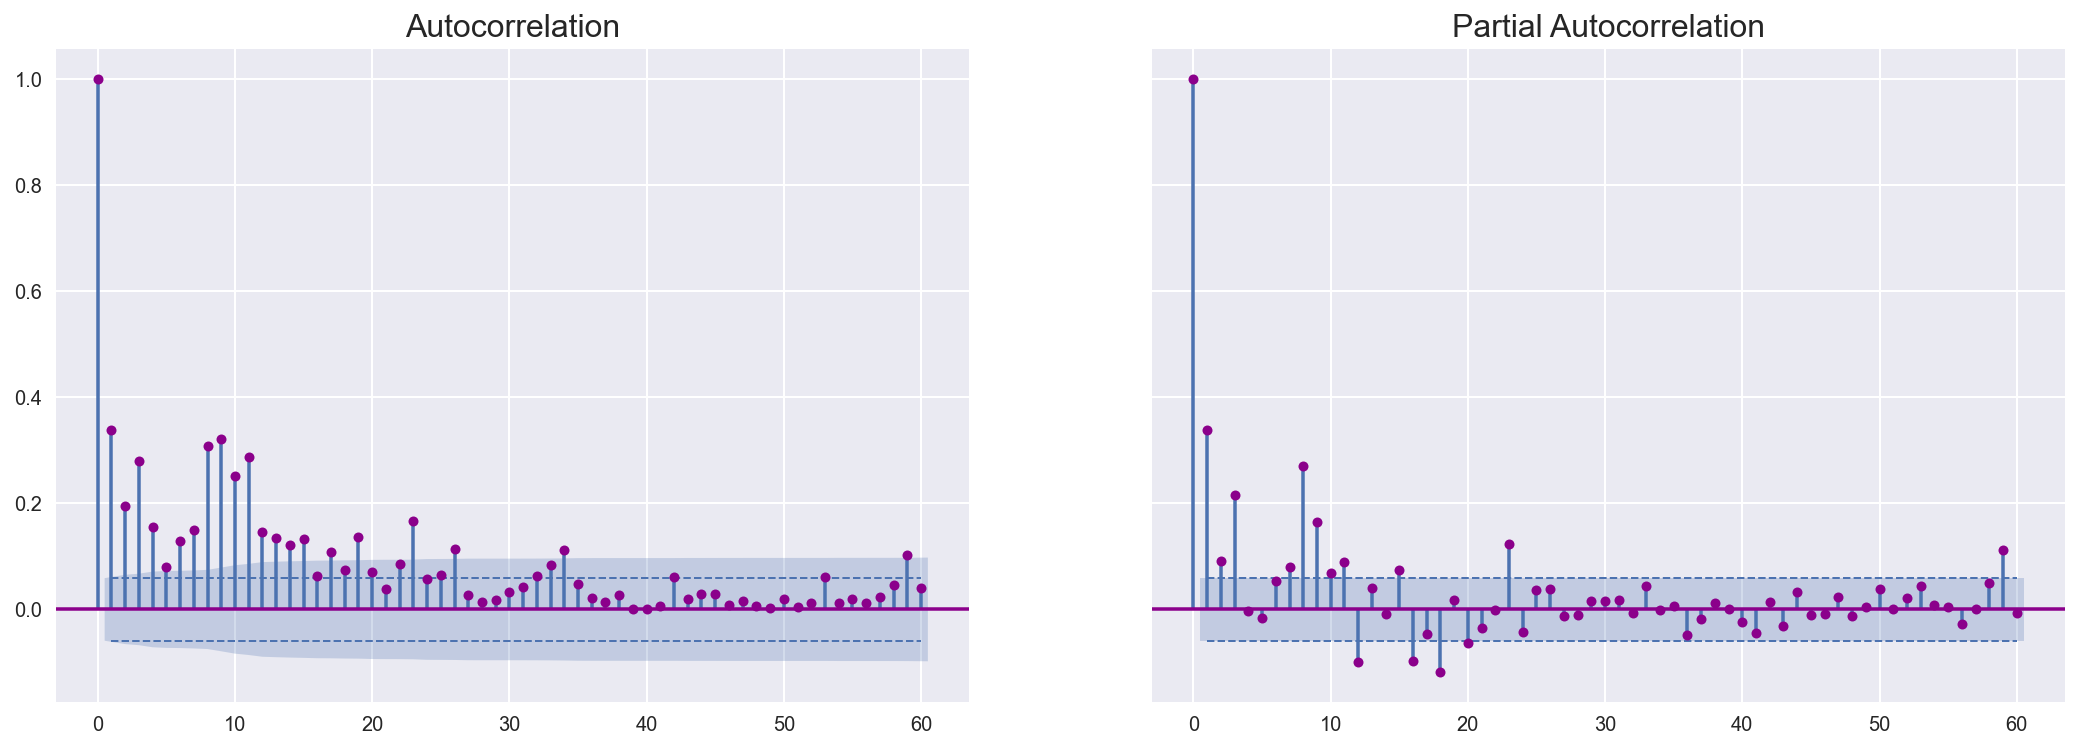

In [41]:
# Monthly squared returns also exhibit serial correlation, but much weaker compared to the daily data
fig, ax = autocorr_plots(dfm.mt_pct_sq, lags=60)

It's immediately obvious that the **absolute magnitude of returns are correlated**, and much **more persistent in the daily data**. So volatile returns (both larger increases _and_ declines in prices) tend **cluster together in particular periods**, and vice-versa. This is a bigger problem for the daily returns series than the monthly one however.

# Simulating returns using historical daily returns data

### Create two different period datasets

In [42]:
# DF with all 1928 data through 2019
df_2819 = df.loc[(df.index >= '1928-01-03') & (df.index <= '2019-12-31')]

In [43]:
# DF with all 1990 data through 2019, thus covering the more recent period
df_9019 = df.loc[(df.index >= '1990-01-01') & (df.index <= '2019-12-31')]

In [44]:
df_2819.head(-10)

,price,pct,dy_pct,dy_pct_sq
date,,,,
1928-01-03,17.76,NaN,0.005663,3.206407e-05
1928-01-04,17.72,NaN,-0.002252,5.072640e-06
1928-01-05,17.55,NaN,-0.009594,9.203869e-05
1928-01-06,17.66,NaN,0.006268,3.928540e-05
1928-01-09,17.50,NaN,-0.009060,8.208401e-05
...,...,...,...,...
2019-12-10,3132.52,0.018116,-0.001097,1.203305e-06
2019-12-11,3141.63,0.018297,0.002908,8.457637e-06
2019-12-12,3168.57,0.024406,0.008575,7.353348e-05


In [45]:
df_9019.head(-10)

,price,pct,dy_pct,dy_pct_sq
date,,,,
1990-01-02,359.69,0.040258,0.017799,3.167876e-04
1990-01-03,358.76,0.044121,-0.002586,6.685119e-06
1990-01-04,355.67,0.027978,-0.008613,7.418377e-05
1990-01-05,352.20,0.004478,-0.009756,9.518412e-05
1990-01-08,353.79,0.006773,0.004514,2.038053e-05
...,...,...,...,...
2019-12-10,3132.52,0.018116,-0.001097,1.203305e-06
2019-12-11,3141.63,0.018297,0.002908,8.457637e-06
2019-12-12,3168.57,0.024406,0.008575,7.353348e-05


### Simulation functions

Undertake the simulations using **NumPy arrays** to make them run faster

In [46]:
def simulation(hist_data, period_fwd):
    '''
    Simple simulation function for sampling with replacement
    Arguments:
    hist_data: NumPy array containing data
    period_fwd: Integer for number of simulation periods
    '''
    return np.random.choice(hist_data, size=period_fwd, replace=True)

In [47]:
def sim_multiperiods(hist_data, period_fwd, n_iterations):
    '''
    Simulation function for sampling with replacement multiple times
    Arguments:
    hist_data: NumPy array containing data
    period_fwd: Integer for number of simulation periods
    n_iterations: Integer for number of simulations
    '''
    # Initialize an empty dictionary to hold all the simulated columns of returns
    sim_dict = {}
    
    for i in range(n_iterations):
        z = simulation(hist_data, period_fwd).tolist() # Output is 1D Numpy array, then convert to list
        sim_dict['returns_%d' % (i)] = z

    # Transform dictionary into Pandas DataFrame        
    sim_dist = pd.DataFrame.from_dict(sim_dict) 
        
    return sim_dist

In [48]:
# Setting 21 days ahead simulation of returns with 10,000 iterations
period_fwd = 21
n_iterations = 10000

### Simulation results

In [49]:
# Transform DF column of returns to NumPy array first
sim_dist1 = sim_multiperiods(df_2819.dy_pct.to_numpy(), period_fwd, n_iterations)

In [50]:
sim_dist1.head(5)

,returns_0,returns_1,returns_2,returns_3,returns_4,returns_5,returns_6,returns_7,returns_8,returns_9,...,returns_9990,returns_9991,returns_9992,returns_9993,returns_9994,returns_9995,returns_9996,returns_9997,returns_9998,returns_9999
0,-0.001712,-0.005612,-0.000189,-0.006094,0.002701,0.014175,0.002636,0.017575,-0.007705,-0.007964,...,0.005030,-0.000635,0.009922,-0.002764,0.004900,0.000295,0.047374,-0.001686,-0.001114,0.007509
1,-0.002628,-0.005310,0.012192,0.019387,-0.008809,-0.031995,0.000468,-0.005914,0.000364,-0.007826,...,0.002124,-0.000007,0.001888,0.000311,0.001863,0.001126,0.005946,0.000568,-0.016675,0.003364
2,-0.001883,-0.005362,0.027778,0.008400,0.006750,-0.019048,-0.001589,-0.011580,-0.000361,-0.003210,...,-0.000993,0.003335,0.016430,-0.006700,-0.007976,0.006038,0.002568,0.002829,0.008852,-0.001642
3,0.002706,-0.001660,0.004510,0.002299,0.002825,0.010673,0.000954,-0.002740,-0.002955,-0.007464,...,-0.002848,-0.014302,-0.003199,-0.005128,-0.002146,-0.015740,0.001251,-0.003293,-0.015216,0.006845
4,0.011710,0.004747,-0.011287,0.005663,-0.000770,0.009341,-0.002624,0.000000,-0.007003,0.001837,...,0.003770,0.005223,-0.005290,0.009756,-0.000435,0.004938,-0.008751,-0.002060,0.003023,0.002285


In [51]:
# Generate a DF with the cumulative returns
snp_cumulative1 = (sim_dist1 + 1).cumprod()

In [52]:
# DF of the cumulative returns
snp_cumulative1.head(25)

,returns_0,returns_1,returns_2,returns_3,returns_4,returns_5,returns_6,returns_7,returns_8,returns_9,...,returns_9990,returns_9991,returns_9992,returns_9993,returns_9994,returns_9995,returns_9996,returns_9997,returns_9998,returns_9999
0,0.998288,0.994388,0.999811,0.993906,1.002701,1.014175,1.002636,1.017575,0.992295,0.992036,...,1.005030,0.999365,1.009922,0.997236,1.004900,1.000295,1.047374,0.998314,0.998886,1.007509
1,0.995664,0.989108,1.012001,1.013175,0.993868,0.981726,1.003105,1.011558,0.992655,0.984273,...,1.007164,0.999358,1.011829,0.997546,1.006772,1.001421,1.053601,0.998881,0.982230,1.010898
2,0.993789,0.983804,1.040112,1.021686,1.000576,0.963027,1.001512,0.999844,0.992297,0.981113,...,1.006164,1.002691,1.028453,0.990862,0.998743,1.007468,1.056308,1.001707,0.990925,1.009238
3,0.996478,0.982172,1.044803,1.024035,1.003403,0.973305,1.002467,0.997105,0.989365,0.973790,...,1.003299,0.988350,1.025164,0.985781,0.996599,0.991610,1.057629,0.998409,0.975847,1.016146
4,1.008146,0.986834,1.033011,1.029834,1.002631,0.982397,0.999836,0.997105,0.982436,0.975579,...,1.007081,0.993513,1.019740,0.995398,0.996166,0.996506,1.048374,0.996351,0.978797,1.018468
5,0.993047,0.974335,1.033362,1.047601,1.006159,0.978533,1.010498,1.007750,0.962060,0.973736,...,1.004935,0.996062,1.016931,1.008343,1.011546,0.974873,1.025615,0.999966,0.978894,1.023186
6,0.999239,0.972377,1.040297,1.043911,1.005195,0.986573,1.010774,1.005352,0.963007,0.989701,...,1.012570,0.984499,1.019171,1.001556,1.008126,0.970050,1.025170,0.993786,0.940443,1.024968
7,1.004734,0.978103,1.045299,1.038112,1.010964,0.987870,1.006806,1.014409,0.958678,0.991710,...,1.014180,0.986932,0.986806,1.003922,1.009992,0.968616,1.034289,1.000580,0.935784,1.017234
8,1.009206,0.992130,1.043863,1.023876,1.008946,0.983503,1.003551,1.055724,0.962435,0.982376,...,1.025055,0.999045,0.956155,1.007796,0.993550,0.968616,1.026393,0.963085,0.934174,1.026575
9,1.011084,0.983854,1.063087,1.014667,1.023981,0.984739,1.000676,1.041848,0.966757,0.996561,...,0.998965,0.999999,0.946946,1.013891,0.996787,0.963115,1.023737,0.964028,0.932645,0.997144


In [53]:
# Extract the row of simulated cumulative returns as per the final 21st day
cumulative_2819D = snp_cumulative1.iloc[-1]-1

In [54]:
print(f"Mean of the simulated returns, 1928-2019 daily data: {np.mean(cumulative_2819D):0.4f}")
print(f"5th percentile of the simulated returns, 1928-2019 daily data: {np.percentile(cumulative_2819D,5):0.4f}") 
print(f"1st percentile of the simulated returns, 1928-2019 daily data: {np.percentile(cumulative_2819D,1):0.4f}")
print(f"0.1 percentile of the simulated returns, 1928-2019 daily data: {np.percentile(cumulative_2819D,0.1):0.4f}")
print(f"The minimum value of the simulated returns, 1928-2019 daily data: {min(cumulative_2819D):0.4f}")

Mean of the simulated returns, 1928-2019 daily data: 0.0054
5th percentile of the simulated returns, 1928-2019 daily data: -0.0795
1st percentile of the simulated returns, 1928-2019 daily data: -0.1171
0.1 percentile of the simulated returns, 1928-2019 daily data: -0.1700
The minimum value of the simulated returns, 1928-2019 daily data: -0.2246


The most negative cumulative return over those 21 days was just slightly over **-22%**, according to the simulation, but this is still better than using just the more recent 1990-2019 daily returns data, as we see below.

In [55]:
# Doing the same with the subset of more recent 1990-2019 daily data 
sim_dist2 = sim_multiperiods(df_9019.dy_pct.to_numpy(), period_fwd, n_iterations)

In [56]:
snp_cumulative2 = (sim_dist2 + 1).cumprod()

In [57]:
snp_cumulative2.head(25)

,returns_0,returns_1,returns_2,returns_3,returns_4,returns_5,returns_6,returns_7,returns_8,returns_9,...,returns_9990,returns_9991,returns_9992,returns_9993,returns_9994,returns_9995,returns_9996,returns_9997,returns_9998,returns_9999
0,1.013531,1.001071,1.010949,1.010630,1.010109,0.985556,0.994006,1.006715,1.003672,1.000951,...,1.013705,0.995802,0.999754,1.012189,1.000522,1.000843,1.004931,0.996103,1.011088,1.002687
1,1.019917,0.992376,1.016586,1.026259,1.021426,0.980226,0.997946,1.011353,0.996225,1.003610,...,1.015159,0.987715,1.002208,0.964482,1.007665,0.984127,1.008358,1.002192,1.006131,1.005296
2,1.026118,0.992740,1.017436,1.022643,1.008943,0.960753,0.980049,1.010893,1.002741,0.962483,...,1.001422,0.983906,1.013011,0.959853,1.021824,0.989391,1.004685,0.998307,1.020161,1.003723
3,1.019346,0.979412,1.033797,1.027908,1.018475,0.961168,0.939182,1.009164,0.997929,0.966566,...,0.990854,0.986744,0.988015,0.957078,0.998955,0.982476,1.015780,1.004837,1.008600,1.006221
4,1.028102,0.985467,1.037233,1.030663,1.022281,0.968658,0.923180,1.017220,0.981495,0.958742,...,0.997597,0.996233,0.988829,0.951984,1.004883,0.991071,1.014475,0.998079,1.014919,1.008087
5,1.032372,1.000974,1.029946,1.027443,1.015440,0.967640,0.927338,1.007537,0.981839,0.963756,...,0.987118,0.969316,0.993796,0.958379,1.011330,1.015782,1.005943,1.036926,1.036088,1.005629
6,1.037590,0.995289,1.035848,1.041246,1.016098,0.959808,0.933161,1.007178,0.988561,0.935254,...,0.986079,0.970449,0.991347,0.963843,1.000125,1.036523,1.002681,1.039250,1.042460,0.996770
7,1.036423,0.984324,1.034123,1.046984,1.025031,0.963141,0.923171,0.974953,1.002009,0.922081,...,0.984496,0.978900,0.981938,0.969808,1.004554,1.034084,1.008204,1.030835,1.052635,1.002935
8,1.048599,0.984348,1.027011,1.033161,1.026786,0.973796,0.930877,0.974147,1.010671,0.918789,...,0.986448,0.978347,0.986679,0.990348,1.005357,1.033411,1.005256,1.020260,1.061311,1.020173
9,1.048574,0.992299,1.042720,1.009621,1.030563,0.981040,0.929647,0.975910,1.015293,0.922432,...,0.971600,0.985372,0.989416,0.997129,1.011119,1.033052,1.006472,1.024588,1.061454,1.002400


In [58]:
# Extract the simulated cumulative returns for the 21st day
cumulative_9019D = snp_cumulative2.iloc[-1]-1

In [59]:
print(f"Mean of the simulated returns, 1990-2019 daily data: {np.mean(cumulative_9019D):0.4f}") 
print(f"5th percentile of the simulated returns, 1990-2019 daily data: {np.percentile(cumulative_9019D,5):0.4f}") 
print(f"1st percentile of the simulated returns, 1990-2019 daily data: {np.percentile(cumulative_9019D,1):0.4f}")
print(f"0.1 percentile of the simulated returns, 1990-2019 daily data: {np.percentile(cumulative_9019D,0.1):0.4f}")
print(f"The minimum value of the simulated returns, 1990-2019 daily data: {min(cumulative_9019D):0.4f}")

Mean of the simulated returns, 1990-2019 daily data: 0.0061
5th percentile of the simulated returns, 1990-2019 daily data: -0.0754
1st percentile of the simulated returns, 1990-2019 daily data: -0.1148
0.1 percentile of the simulated returns, 1990-2019 daily data: -0.1609
The minimum value of the simulated returns, 1990-2019 daily data: -0.1984


The simulated left-tail of the S&P500's **21-day cumulative returns using 1990-2019 data** had a decline almost **20% in its absolutely worst case**. However, the simulated **cumulative returns using 1928-2019 data encountered a decline of approximately 22%**. So there is a difference between the results of the simulation based on the breadth of the historical data used. Basically restricting the sample to the more recent 1990-2019 sample period would have let us to **underestimate the worst-case scenario**. In fact, the extreme left-tail percentiles from the simulation using the more recent 1990-2019 data were all larger than those from the 1928-2019 series.

Nonetheless, it is obvious that **neither of the daily returns series** came close to simulating the realised **34% drop in February-March 2020** when looking at the 1st or 0.1 percential figures. One reason for this underestimation is the volatility clustering that was highlighted above. So let us see if we can improve on the stimulation results by using monthly returns.

## Simulating forward returns using historical monthly returns data

The 23-day tumble in the SPX in February-March 2020 almost neatly coincided with a month of returns. A month has 21-22 trading days on average. Given that **monthly returns distributions are closer to a normal distribution** (than the daily series) and more importantly, **monthly returns exhibit less non-linear serial correlation** than daily returns, we run the simulation using **monthly returns**.

In [60]:
# Setting one period (equivalent to 21 days) ahead simulation of returns, with 5,000 iterations. Since there are just
# slightly over 1,000 distinct calendar months in the years between 1928 and 2019, let's not overkill the sampling.
period_fwd = 1
n_iterations = 5000

In [61]:
sim_dist3 = sim_multiperiods(dfm.mt_pct.to_numpy(), period_fwd, n_iterations)

In [62]:
# There is only one row in this simulation, as there is only one period ahead being simulated
sim_dist3

,returns_0,returns_1,returns_2,returns_3,returns_4,returns_5,returns_6,returns_7,returns_8,returns_9,...,returns_4990,returns_4991,returns_4992,returns_4993,returns_4994,returns_4995,returns_4996,returns_4997,returns_4998,returns_4999
0,0.058984,0.026277,-0.047449,0.000864,0.005072,-0.024772,-0.202462,0.091989,0.019742,0.035713,...,0.015152,0.047964,0.036856,0.019763,0.025544,-0.109931,-0.010772,0.078178,0.036033,-0.029736


In [63]:
print(f"Mean of the simulated returns, 1928-2019 monthly data: {np.mean(sim_dist3.iloc[0]):0.4f}") 
print(f"5th percentile of the simulated returns, 1928-2019 monthly data: {np.percentile(sim_dist3.iloc[0],5):0.4f}") 
print(f"1st percentile of the simulated returns, 1928-2019 monthly data: {np.percentile(sim_dist3.iloc[0],1):0.4f}")
print(f"0.1 percentile of the simulated returns, 1928-2019 monthly data: {np.percentile(sim_dist3.iloc[0],0.1):0.4f}")
print(f"The minimum value of the simulated returns, 1928-2019 monthly data: {min(sim_dist3.iloc[0]):0.4f}")

Mean of the simulated returns, 1928-2019 monthly data: 0.0057
5th percentile of the simulated returns, 1928-2019 monthly data: -0.0782
1st percentile of the simulated returns, 1928-2019 monthly data: -0.1694
0.1 percentile of the simulated returns, 1928-2019 monthly data: -0.2994
The minimum value of the simulated returns, 1928-2019 monthly data: -0.2994


The simulated drawdowns using the **calendar month returns** data provide uniformly **deeper drawdown percentiles** across the board compared to the daily returns series simulations. The **0.1 percentile at approximately -30%** was far lower than the comparable estimates from the daily series, and almost approaching the -34% in February-March 2020.

## Repeat exercise for quarterly returns

In [64]:
# Setting 63 days ahead simulation of returns with 10,000 iterations
period_fwd = 63
n_iterations = 10000

In [65]:
sim_dist4 = sim_multiperiods(df_2819.dy_pct.to_numpy(), period_fwd, n_iterations)

In [66]:
snp_cumulative4 = (sim_dist4 + 1).cumprod()

In [67]:
snp_cumulative4.head(65)

,returns_0,returns_1,returns_2,returns_3,returns_4,returns_5,returns_6,returns_7,returns_8,returns_9,...,returns_9990,returns_9991,returns_9992,returns_9993,returns_9994,returns_9995,returns_9996,returns_9997,returns_9998,returns_9999
0,1.027536,0.986907,0.969933,0.999989,1.002330,1.001554,1.008351,1.001930,1.017773,0.973631,...,1.007650,0.996060,1.006450,0.993522,1.006776,0.996462,1.005564,0.989735,1.001717,0.997553
1,1.008138,0.990501,0.944475,0.991782,1.005282,0.995740,1.002816,0.995452,1.027344,1.062225,...,1.008785,1.004043,1.008536,0.993084,1.002590,0.987961,0.991149,0.998434,0.991394,0.993914
2,0.986884,1.007536,0.998607,0.993273,1.007701,0.992477,1.004590,0.993499,1.037140,1.062261,...,1.000817,1.004043,1.014227,1.000369,1.009736,0.966353,0.979640,0.996171,0.997219,1.030191
3,0.989614,1.014819,0.973191,1.025212,1.025216,0.994012,1.010519,0.969635,1.036351,1.058396,...,0.991322,1.001396,1.014010,1.000369,1.015253,0.968315,0.987191,1.000947,0.987198,1.027495
4,0.989614,1.008454,0.985885,1.027069,1.027542,0.994595,1.008138,0.976099,1.041540,1.069570,...,0.993115,0.998814,1.008153,1.005249,1.019174,0.976149,0.985886,0.985399,0.980722,1.019201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0.991257,1.072519,1.001890,1.049530,0.937300,0.937850,1.049663,0.964775,1.183511,1.164185,...,1.043354,1.030150,1.042556,0.988010,0.923151,1.127810,0.983167,0.969563,1.101409,0.878972
59,0.995294,1.074128,1.002716,1.048283,0.929861,0.945421,1.060882,0.963003,1.183520,1.170972,...,1.051197,1.025547,1.049645,0.989382,0.913967,1.138123,0.978033,0.965904,1.107857,0.886410
60,0.985910,1.063185,1.005826,1.050564,0.934609,0.944027,1.053112,0.962253,1.198894,1.164825,...,1.046650,1.029799,1.065309,0.989382,0.914663,1.144298,0.978033,0.968471,1.110191,0.889747
61,0.991779,1.063764,1.012124,1.064918,0.910359,0.942986,1.051785,0.963834,1.196091,1.157488,...,1.033479,1.028423,1.068639,0.985295,0.895904,1.157701,0.977077,0.970238,1.112186,0.878111


In [68]:
cumulative_2819Q = snp_cumulative4.iloc[-1]-1

In [69]:
print(f"Mean of the simulated returns, 1928-2019 daily data: {np.mean(cumulative_2819Q):0.4f}") 
print(f"5th percentile of the simulated returns, 1928-2019 daily data: {np.percentile(cumulative_2819Q,5):0.4f}") 
print(f"1st percentile of the simulated returns, 1928-2019 daily data: {np.percentile(cumulative_2819Q, 1):0.4f}")
print(f"0.1 percentile of the simulated returns, 1928-2019 daily data: {np.percentile(cumulative_2819Q, 0.1):0.4f}")
print(f"The minimum value of the simulated returns, 1928-2019 daily data: {min(cumulative_2819Q):0.4f}")

Mean of the simulated returns, 1928-2019 daily data: 0.0188
5th percentile of the simulated returns, 1928-2019 daily data: -0.1324
1st percentile of the simulated returns, 1928-2019 daily data: -0.1903
0.1 percentile of the simulated returns, 1928-2019 daily data: -0.2515
The minimum value of the simulated returns, 1928-2019 daily data: -0.3377


### Now for the simulation using calendar quarter data

In [70]:
# There are less than 400 distinct quarters in the 1928-2019 period, so let's do with 2000 iterations
period_fwd = 1
n_iterations = 2000

In [71]:
sim_dist5 = sim_multiperiods(dfq.qt_pct.to_numpy(), period_fwd, n_iterations)

In [72]:
print(f"Mean of the simulated returns, 1928-2019 quarterly data: {np.mean(sim_dist5.iloc[0]):0.4f}") 
print(f"5th percentile of the simulated returns, 1928-2019 quarterly data: {np.percentile(sim_dist5.iloc[0],5):0.4f}") 
print(f"1st percentile of the simulated returns, 1928-2019 quarterly data: {np.percentile(sim_dist5.iloc[0],1):0.4f}")
print(f"0.1 percentile of the simulated returns, 1928-2019 quarterly data: {np.percentile(sim_dist5.iloc[0],0.1):0.4f}")
print(f"The minimum value of the simulated returns, 1928-2019 quarterly  data: {min(sim_dist5.iloc[0]):0.4f}")

Mean of the simulated returns, 1928-2019 quarterly data: 0.0216
5th percentile of the simulated returns, 1928-2019 quarterly data: -0.1499
1st percentile of the simulated returns, 1928-2019 quarterly data: -0.2333
0.1 percentile of the simulated returns, 1928-2019 quarterly data: -0.3452
The minimum value of the simulated returns, 1928-2019 quarterly  data: -0.3940


The mean quarterly returns from both sets of simulations are similar, at approximately 2%. But the estimates diverge widely as we go out along the **tails of the sampling distributions**. We see that the aggregated returns built-up from the daily return simulations again **underestimate the left-tail risk** of extended stock market drawdowns.